In [5]:
#INFORMATION ABOUT CNN

#TRANSFORMATION scales from interval [0, 255] to [0.0, 1.0] and then Normalization x_new = (x-mean)/std

#BATCH_SIZE = 64

#----NUMBER OF PARAMETERS CNN----

# input image has size 227*227

#conv1: 4*4*3*10 + 10 = 490 -> 4*4 filter, 3 input image channels, 10 number of filters, +10 bias parameters of each filter
#conv2: 5*5*10*15 + 15 = 3765
#conv3: 6*6*15*20 + 20 = 10820
#conv4: 3*3*20*25 + 25 = 4525

#after conv4 layer: output "image": 3*3*25 = 225

#fc1: 225*45 + 45 = 10170 -> fc1 has 45 output features
#fc2: 45*20 + 20 = 920
#fc3: 20*2 + 2 = 42

#TOTAL CNN: 30732 parameters

#----NUMBER OF PARAMETERS CNN----

#---- CURRENT RESULTS ----

# --- Epoch: 0, train loss: 0.0547, train acc: 0.9920, time: 185.72551941871643
#Epoch: 0, test loss: 0.5021, test acc: 0.8298, time: 982.3053231239319

# --- Epoch: 1, train loss: 0.0054, train acc: 0.9990, time: 1167.7591831684113
#Epoch: 1, test loss: 0.3759, test acc: 0.9193, time: 1233.2979555130005

# --- Epoch: 2, train loss: 0.0047, train acc: 0.9988, time: 1410.846270084381
#Epoch: 2, test loss: 1.0650, test acc: 0.8194, time: 1476.1876842975616

# --- Epoch: 3, train loss: 0.0022, train acc: 0.9993, time: 1649.150539636612
#Epoch: 3, test loss: 0.6330, test acc: 0.8666, time: 1713.3415627479553

# --- Epoch: 4, train loss: 0.0003, train acc: 1.0000, time: 1887.5666482448578
#Epoch: 4, test loss: 0.8888, test acc: 0.8573, time: 1951.4360206127167

# --- Epoch: 5, train loss: 0.0040, train acc: 0.9987, time: 2124.932951927185
#Epoch: 5, test loss: 0.6418, test acc: 0.8751, time: 2189.122528076172

# --- Epoch: 6, train loss: 0.0012, train acc: 0.9996, time: 2360.4124615192413
#Epoch: 6, test loss: 0.7349, test acc: 0.8451, time: 2422.3692615032196

# --- Epoch: 7, train loss: 0.0002, train acc: 1.0000, time: 2594.427927017212
#Epoch: 7, test loss: 0.5947, test acc: 0.9201, time: 2659.300325155258

#---- ----CLASSIFIED WRONG---- ----
#person E, G, S have been shifted only to the test dataset

#persons in test dataset that have been classified in a wrong way

#E    278/962  = 28.9%
#e     34/1000 = 3.4%

#G      5/499  = 1.0%
#g    108/109  = 99.1%

#S      8/487  = 1.6%
#s    457/457  = 100.0%

#k      1/538  = 0.19%

#---- CURRENT RESULTS ----

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

from PIL import Image

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import re
import os
import numpy as np
import re

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt

import math

In [7]:

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [3]:
"""from google.colab import drive
drive.mount('/content/drive')
!unzip -uq "/content/drive/MyDrive/DDD Project/Driver Drowsiness Dataset (DDD)/archive.zip"
"""

'from google.colab import drive\ndrive.mount(\'/content/drive\')\n!unzip -uq "/content/drive/MyDrive/DDD Project/Driver Drowsiness Dataset (DDD)/archive.zip"\n'

In [8]:
#DATAFRAME OF ALL PICTURES, TAKEOUT SPECIFIC PERSONS, 

#create a pandas dataframe out of all pictures in the dataset
#---- ---- ----
# Add image paths, labels, file names and person IDs into lists
image_path, label, file_name, person_ID = [], [], [], []

#for the person_ID - identification criteria of participant
pattern = re.compile(r'^[a-zA-Z][a-zA-Z]?')



#data_dir = "/content/drive/MyDrive/newdata/Driver Drowsiness Dataset (DDD)/"

## HPC cluster method
path = os.getcwd()
data_dir = path + str('/Driver Drowsiness Dataset (DDD)/')


for class_name in os.listdir(data_dir):  #goes through all folders in DDD folder
  for path in os.listdir(data_dir+class_name):  #goes through all files in both folders and updates file path and labels
    if class_name == 'Drowsy':
      label.append(0)
    else:
      label.append(1)
    image_path.append(os.path.join(data_dir, class_name, path))
    file_name.append(path)

    person_ID.append(pattern.findall(path)[0])  #identification of participant


#dataframe with path, label, file name, person_ID of all Persons
df = pd.DataFrame()
df['images'] = image_path
df['label'] = label
df['name'] = file_name
df['person'] = person_ID

print('df')
print(df.shape)
#---- ---- ----

#split pandas dataframe with all pictures into dfTest with person E, G, S and dfWithout with all pictures except of E, G, S
#---- ---- ---- ---- ---- ----
#add Person E and G only to the Test Dataset
dfTest = pd.concat([df[df['person']=='o'], df[df['person']=='O'], df[df['person']=='p'], df[df['person']=='P'], df[df['person']=='zb'], df[df['person']=='ZB']])
print('dfTest')
print(dfTest.shape)


#remove Person E and G from the dataset with all Persons
dfWithout = df
dfWithout = dfWithout.drop(index=(df[df['person']=='o'].index))
dfWithout = dfWithout.drop(index=(df[df['person']=='O'].index))
dfWithout = dfWithout.drop(index=(df[df['person']=='p'].index))
dfWithout = dfWithout.drop(index=(df[df['person']=='P'].index))

dfWithout = dfWithout.drop(index=(df[df['person']=='zb'].index))
dfWithout = dfWithout.drop(index=(df[df['person']=='ZB'].index))

print('dfWithout')
print(dfWithout.shape)
#---- ---- ---- ---- ---- ----


#converting imagepath and label of takeout persons G, E, S into an nparray
#----
imagePathTakeout = dfTest['images']
labelTakeout = dfTest['label']

imagePathTO = np.array(imagePathTakeout).reshape([-1,1])
labelTO = np.array(labelTakeout).reshape([-1,1])
testTO = np.hstack((imagePathTO, labelTO))

print('testTO')
print(testTO.shape)
#----


#converting imagepath and label of all other persons into an nparray
#---- ----
imagePathWithout = dfWithout['images']
labelWithout = dfWithout['label']

image_path = np.array(imagePathWithout).reshape([-1,1])
label = np.array(labelWithout).reshape([-1,1])
comp_data = np.hstack((image_path, label))
#---- ----

df
(41793, 4)
dfTest
(5709, 4)
dfWithout
(36084, 4)
testTO
(5709, 2)


In [9]:


print(testTO)
     


[['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/o0383.png'
  1]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/o0708.png'
  1]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/o0072.png'
  1]
 ...
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/ZB1646.png'
  0]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/ZB1021.png'
  0]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/ZB1612.png'
  0]]


In [10]:

#number of images of ALL persons of the dataset
result = df.groupby("person").size()
print(result)


person
A     1411
B      315
C      335
D      179
E      962
F      415
G      499
H      508
I     1095
J      474
K      630
L      732
M      777
N     1156
O     1097
P      963
Q      562
R      204
S      487
T      933
U      420
V      653
W     1162
X     1749
Y     1112
ZA     621
ZB    1551
ZC    1346
a     1252
b      409
c      400
d     1005
e     1000
g      109
h      571
i     1045
j      717
k      538
l      381
m      473
n      957
o      671
p      190
q      521
r      522
s      457
u      510
v     1002
w      493
x     1143
y     1500
za    1054
zb    1237
zc    1288
dtype: int64


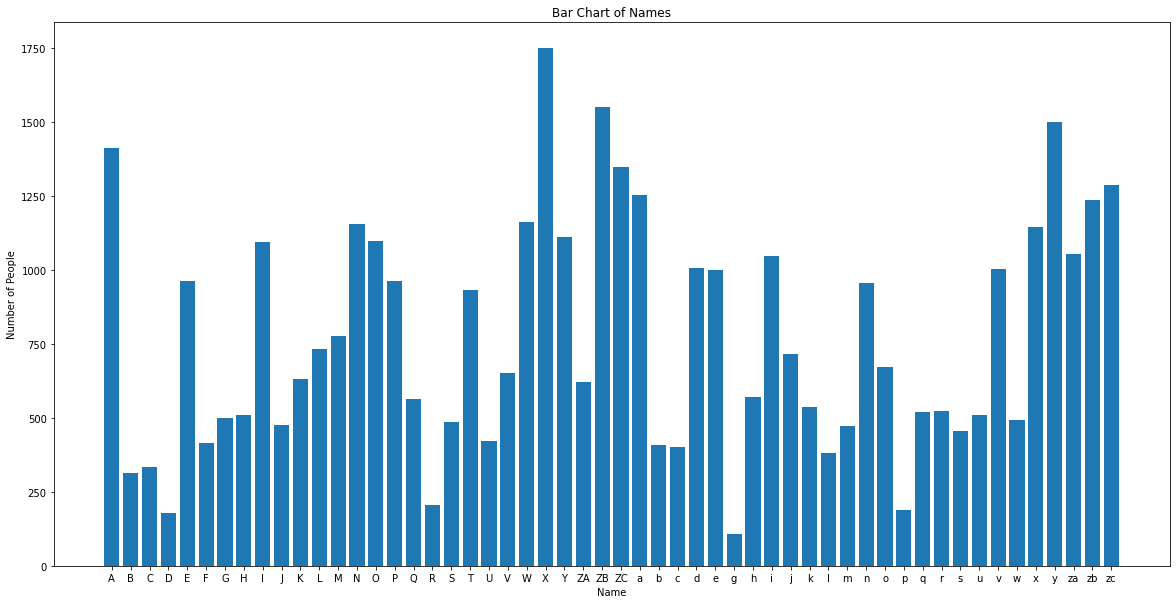

In [11]:
#plotting barchart of All persons
plt.figure(figsize=(20,10))
plt.bar(result.index, result.values, )
plt.xlabel('Name')
plt.ylabel('Number of People')
plt.title('Bar Chart of Names')
plt.show()

In [12]:
#CREATE TRAIN DATASET AND TEST DATASET

from sklearn.model_selection import train_test_split


#nparray with all other persons (except of E, G, S) gets split into train and test dataset
trainW, testW = train_test_split(comp_data, test_size=0.2, random_state=1234)
print('trainW')
print(trainW.shape)

print('testW')
print(testW.shape)


#train dataset
train = trainW


#test dataset is a combination of the takeout of person E, G, S and the part that was split to test via train_test_split
test = np.concatenate((testTO, testW))


print('test')
print(test.shape)
print(train)
     

trainW
(28867, 2)
testW
(7217, 2)
test
(12926, 2)
[['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/l0384.png'
  1]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/ZA0738.png'
  0]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/A0381.png'
  0]
 ...
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/J0227.png'
  0]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/W0414.png'
  0]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/X0620.png'
  0]]


In [13]:
#basic methods of Dataset class need to be overwritten
class DDDdataset(Dataset):
  def __init__(self, image_paths, image_labels, transform):
    super().__init__()
    self.paths = image_paths
    self.labels = image_labels
    self.len = len(self.paths)
    self.transform = transform
  
  def __len__(self): return self.len
  
  def __getitem__(self, index):
    path = self.paths[index]
    label = self.labels[index]
    target_tensor=torch.from_numpy(np.array(label,dtype=np.int16))
    #image = Image.open(path).convert('RGB')
    image = cv2.imread(path,cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = self.transform(image)
    return (image, target_tensor, path)

# Standardisation

In [9]:


#TRANSFORMATION, TRAIN DATASET AND LOADER FOR THE CALCULATION OF MEAN AND STD FOR EVERY CHANNEL

#transformation for the calculation of mean and std for the train dataset
transformationCalc = transforms.Compose([
    #ToTensor() includes an automatic scaling from the interval (0,255) to (0.0,1.0)
    transforms.ToTensor()
])

#train dataset and loader for the calculation of mean and std for the train dataset
trainDatasetCalc = DDDdataset(train[:,0], train[:,-1], transformationCalc)

loaderCalc = DataLoader(trainDatasetCalc, batch_size=128, shuffle=True, num_workers = 8)
     


'#transformation for the calculation of mean and std for the train dataset\ntransformationCalc = transforms.Compose([\n    #ToTensor() includes an automatic scaling from the interval (0,255) to (0.0,1.0)\n    transforms.ToTensor()\n])\n\n#train dataset and loader for the calculation of mean and std for the train dataset\ntrainDatasetCalc = DDDdataset(train[:,0], train[:,-1], transformationCalc)\n\nloaderCalc = DataLoader(trainDatasetCalc, batch_size=128, shuffle=True)'

## Method 1

In [ ]:
#CALCULATION MEAN AND STD FOR EVERY CHANNEL

numberOfPixelsPerImage = 227*227
noOfImages = train.shape[0]


#lists to collect the sum of all pixel values in the batch for R, G, B
sumOfBatchesR, sumOfBatchesG, sumOfBatchesB = [], [], []
squaredSumOfBatchesR, squaredSumOfBatchesG, squaredSumOfBatchesB = [], [], []


#in calcBatch(es) with 128 pictures each perform sum operations
for calcBatch in loaderCalc:
  #calcBatch[0] with dimension (128, 3, 227, 227)
  currentBatch = calcBatch[0]
  #currentBatch = currentBatch.float()


  rgbSumOfBatch = currentBatch.sum(axis=3) #reduce column of one picture to one column (128, 3, 227)
  rgbSumOfBatch = rgbSumOfBatch.sum(axis=2) #reduce row of one picture to one row (128, 3)
  rgbSumOfBatch = rgbSumOfBatch.sum(axis=0) #combine all pictures of the batch to 3 values for rgb (3)

  #sum of the batch for R, G, B is stored for final calculation
  sumOfBatchesR.append(rgbSumOfBatch[0])
  sumOfBatchesG.append(rgbSumOfBatch[1])
  sumOfBatchesB.append(rgbSumOfBatch[2])


  rgbSquaredSumOfBatch = ((currentBatch)**2).sum(axis=3) #reduce column of one picture to one column (128, 227, 3)
  rgbSquaredSumOfBatch = rgbSquaredSumOfBatch.sum(axis=2) #reduce row of one picture to one row (128, 3)
  rgbSquaredSumOfBatch = rgbSquaredSumOfBatch.sum(axis=0) #combine all pictures of the batch to 3 values for rgb (3)

  #squared sum of the batch for R, G, B is stored for final calculation
  squaredSumOfBatchesR.append(rgbSquaredSumOfBatch[0])
  squaredSumOfBatchesG.append(rgbSquaredSumOfBatch[1])
  squaredSumOfBatchesB.append(rgbSquaredSumOfBatch[2])


#final sum for R, G, B
sumOfBatchesR = np.array(sumOfBatchesR).sum()
sumOfBatchesG = np.array(sumOfBatchesG).sum()
sumOfBatchesB = np.array(sumOfBatchesB).sum()

#calculation of the mean for R, G, B
meanR = sumOfBatchesR/(numberOfPixelsPerImage*noOfImages)
meanG = sumOfBatchesG/(numberOfPixelsPerImage*noOfImages)
meanB = sumOfBatchesB/(numberOfPixelsPerImage*noOfImages)

#final squared sum for R, G, B
squaredSumOfBatchesR = np.array(squaredSumOfBatchesR).sum()
squaredSumOfBatchesG = np.array(squaredSumOfBatchesG).sum()
squaredSumOfBatchesB = np.array(squaredSumOfBatchesB).sum()

#final variance
varianceR = (squaredSumOfBatchesR - ((sumOfBatchesR)**2)/(numberOfPixelsPerImage*noOfImages))/(numberOfPixelsPerImage*noOfImages)
varianceG = (squaredSumOfBatchesG - ((sumOfBatchesG)**2)/(numberOfPixelsPerImage*noOfImages))/(numberOfPixelsPerImage*noOfImages)
varianceB = (squaredSumOfBatchesB - ((sumOfBatchesB)**2)/(numberOfPixelsPerImage*noOfImages))/(numberOfPixelsPerImage*noOfImages)

#final std of R, G, B
stdR = math.sqrt(varianceR)
stdG = math.sqrt(varianceG)
stdB = math.sqrt(varianceB)

mean=[meanR, meanG, meanB]
std=[stdR, stdG, stdB]


print(meanR)
print(meanG)
print(meanB)
print('---')
print(stdR)
print(stdG)
print(stdB)

In [15]:
#use this cell to avoid duration of the calculation of mean and std
meanR = 0.5078696757850544
meanG = 0.383553314333379
meanB = 0.3425597905213773

stdR = 0.2523046539381231
stdG = 0.22919015141761262
stdB =0.21377369693134016

mean=[meanR, meanG, meanB]
std=[stdR, stdG, stdB]

## Method 2

In [10]:
"""sum = []
sum = np.zeros((3))
no_of_pixels = len(trainDatasetCalc)*227*227
for batch in loaderCalc: 
  

  for i in range(3) : #no of channels
    
  
    sum[i] += batch[0][:,i,:,:].sum()
  """



'sum = []\nsum = np.zeros((3))\nno_of_pixels = len(trainDatasetCalc)*227*227\nfor batch in loaderCalc: \n  \n\n  for i in range(3) : #no of channels\n    \n  \n    sum[i] += batch[0][:,i,:,:].sum()\n  '

In [11]:
"""mean = sum / no_of_pixels
print(mean)"""

'mean = sum / no_of_pixels\nprint(mean)'

In [12]:
"""sum_sq = []
sum_sq = np.zeros((3))
for batch in loaderCalc:
  for i in range(3) : #no of channels
      
      sum_sq[i] += ((batch[0][:,i,:,:]-mean[i]).pow(2)).sum()"""
      
   

'sum_sq = []\nsum_sq = np.zeros((3))\nfor batch in loaderCalc:\n  for i in range(3) : #no of channels\n      \n      sum_sq[i] += ((batch[0][:,i,:,:]-mean[i]).pow(2)).sum()'

In [13]:
"""std = np.sqrt(sum_sq/no_of_pixels)
print(std)"""

'std = np.sqrt(sum_sq/no_of_pixels)\nprint(std)'

In [14]:
mean = [0.5055243 , 0.3837401 , 0.33682286]
std = [0.24825575, 0.22582591 ,0.21188137]

In [16]:
#TRANSFORMATION, TRAIN DATASET AND LOADER FOR MODEL TRAINING

#transformation for model training and testing
transformation = transforms.Compose([
    #ToTensor() includes an automatic scaling from the interval [0,255] to [0.0,1.0]
    transforms.ToTensor(),
    #Normalization x_new = (x - mean)/std
    transforms.Normalize(mean=mean, std=std)
])


#datasets and dataloaders for model training and testing
trainDataset = DDDdataset(train[:,0], train[:,-1], transformation)
testDataset = DDDdataset(test[:,0], test[:,-1], transformation)

trainDataLoader = DataLoader(trainDataset, batch_size=64, shuffle=True, num_workers = 8)  ## added num_workers parameter here
testDataLoader = DataLoader(testDataset, batch_size=64, shuffle=True, num_workers = 8)  ## added num_workers parameter here

In [17]:

#INFORMATION ABOUT CNN

#transformation scales from interval [0, 255] to [0.0, 1.0] and then Normalization

#batch_size = 64

#----NUMBER OF PARAMETERS CNN below----

# input image has size 227*227

#conv1: 4*4*3*10 + 10 = 490 -> 4*4 filter, 3 input image channels, 10 number of filters, +10 bias parameters of each filter
#conv2: 5*5*10*15 + 15 = 3765
#conv3: 6*6*15*20 + 20 = 10820
#conv4: 3*3*20*25 + 25 = 4525

#after conv4 layer: output "image": 3*3*25 = 225

#fc1: 225*45 + 45 = 10170 -> fc1 has 45 output features
#fc2: 45*20 + 20 = 920
#fc3: 20*2 + 2 = 42

#TOTAL CNN: 30732 parameters

#----NUMBER OF PARAMETERS CNN below----

In [18]:


#LAYERS OF THE MODEL

class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(4,4), stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(10)
    self.conv2 = nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(5,5), stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(15)
    self.conv3 = nn.Conv2d(in_channels=15, out_channels=20, kernel_size=(6,6), stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(20)
    self.conv4 = nn.Conv2d(in_channels=20, out_channels=25, kernel_size=(3,3), stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(25)

    self.fc1 = nn.Linear(in_features=25*3*3, out_features=45)
    self.bn5 = nn.BatchNorm1d(45)
    self.fc2 = nn.Linear(in_features=45, out_features=20)
    self.bn6 = nn.BatchNorm1d(20)
    self.fc3 = nn.Linear(in_features=20, out_features=2)

  def forward(self, X):

    X = F.relu(self.bn1(self.conv1(X)))
    X = F.max_pool2d(X, 2)
    X = F.relu(self.bn2(self.conv2(X)))
    X = F.max_pool2d(X, 2)
    X = F.relu(self.bn3(self.conv3(X)))
    X = F.max_pool2d(X, 3, stride=2)
    X = F.relu(self.bn4(self.conv4(X)))
    X = F.max_pool2d(X, 2)

    X = X.view(X.shape[0], -1)
    X = F.relu(self.bn5(self.fc1(X)))
    X = F.relu(self.bn6(self.fc2(X)))
    X = self.fc3(X)

    return X

     



In [19]:
#MODEL TRAINING AND TESTING

import time

#basic settings
model = CNN().to(device)
number_epochs = 4
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []         # for plotting 
accuracies = []      # for plotting
test_losses = []    # for plotting
test_accuracies = []   # for plotting



#for the analysis of the wrong classifications
pathsOfWrongClassifications = []
rowsOfWrongClassifications = []
correctLabel = []
epochOfWrongClassification = []


start = time.time()
#model training and testing process
for epoch in range(number_epochs):
    
    
  train_preds = []       # for f1score
  test_preds_list = []   # for f1score

  train_class = []     # for f1score
  test_class = []      # for f1score

  epoch_loss = 0
  epoch_accuracy = 0
  
  #-------model training-------
  for (X, y, path) in trainDataLoader:
    X = X.to(device) #torch.as_tensor(X)
    y = y.to(device) #torch.as_tensor(y)
    
    train_class.extend(y.cpu().tolist())   #adds all the true labels in the batches in each epoch to the list
    
    predictions = model(X)
    
    
    pred_class = predictions.argmax(dim=1)         ##finding predicted class labels for f1score
    train_preds.extend(pred_class.cpu().tolist())    #adds all the predicted labels in the batches in each epoch to the list
    
    
    
    loss = loss_func(predictions, y.long())

    #adaption of the neural network
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #
    accuracy = ((predictions.argmax(dim=1) == y).float().mean())
    
    #epoch_accuracy and epoch_loss as it is being plotted cannot be tensor on cuda or have requiresgrad=True 
    epoch_accuracy += accuracy.cpu().detach().numpy()   
    epoch_loss += loss.cpu().detach().numpy()
  
  #total epoch_accuracy and epoch_loss calculation
  epoch_accuracy = epoch_accuracy/len(trainDataLoader)
  accuracies.append(epoch_accuracy)
  epoch_loss = epoch_loss / len(trainDataLoader)
  losses.append(epoch_loss)
  
  # calculating f1_score in train
  f1score = f1_score(train_preds, train_class, average = 'weighted')
  
  print("\n --- Epoch: {}, train loss: {:.4f}, train acc: {:.4f}, f1 score: {:.4f},  time: {}".format(epoch, epoch_loss, epoch_accuracy, f1score, time.time() - start))
  #-------model training-------
  
  
  #---model testing---
  model.eval() #sets the model in evaluation mode
  
  #with disabled gradient calculation
  with torch.no_grad():
    test_epoch_loss = 0
    test_epoch_accuracy = 0

    for test_X, test_y, path in testDataLoader:

      test_X = test_X.to(device)
      test_y = test_y.to(device)
        
      test_class.extend(test_y.cpu().tolist())   #adds all the true labels in the batches in each epoch to the list

      test_preds = model(test_X)
      
      test_pred_class = test_preds.argmax(dim=1)    #finding predicted class labels for f1score  
      test_preds_list.extend(test_pred_class.cpu().tolist())   #adds all the predicted labels in the batches in each epoch to the list
    
    
      test_loss = loss_func(test_preds, test_y.long())
      
      
        
      test_epoch_loss += test_loss.cpu().numpy()            
      test_accuracy = ((test_preds.argmax(dim=1) == test_y).float().mean())
      test_epoch_accuracy += test_accuracy.cpu().numpy()

      #if test prediction is wrong save the path of the image that has been classified wrong
      for index, row in enumerate(test_preds):
        if row.argmax(dim=0) != test_y[index]:
          pathsOfWrongClassifications.append(path[index])
          if rowsOfWrongClassifications == []:
            row = row.cpu()
            rowsOfWrongClassifications = row
          else:
            row = row.cpu()
            rowsOfWrongClassifications = np.vstack([rowsOfWrongClassifications, row])
          correctLabel.append(test_y[index].item())
          epochOfWrongClassification.append(epoch)

    #total test_epoch_accuracy and test_epoch_loss calculation
    
    test_epoch_accuracy = test_epoch_accuracy/len(testDataLoader)
    test_accuracies.append(test_epoch_accuracy)   #for plotting
    
    test_epoch_loss = test_epoch_loss / len(testDataLoader)
    test_losses.append(test_epoch_loss)           #for plotting
    
    f1score_test = f1_score(test_preds_list, test_class, average = 'weighted')
    
    print("Epoch: {}, test loss: {:.4f}, test acc: {:.4f}, f1score: {:.4f}, time: {}\n".format(epoch, test_epoch_loss, test_epoch_accuracy,f1score_test, time.time() - start))
  #---model testing---

  model.train(mode=True) #sets the model back in training mode


 --- Epoch: 0, train loss: 0.0768, train acc: 0.9913, f1 score: 0.9913,  time: 22.417044401168823


/w0/tmp/slurm_ko617013.34285995/ipykernel_116739/432953991.py:113: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if rowsOfWrongClassifications == []:


Epoch: 0, test loss: 0.5026, test acc: 0.8399, f1score: 0.8463, time: 30.725297927856445


 --- Epoch: 1, train loss: 0.0041, train acc: 0.9995, f1 score: 0.9995,  time: 52.10543513298035


/w0/tmp/slurm_ko617013.34285995/ipykernel_116739/432953991.py:113: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if rowsOfWrongClassifications == []:


Epoch: 1, test loss: 0.3188, test acc: 0.8474, f1score: 0.8467, time: 60.01157808303833


 --- Epoch: 2, train loss: 0.0054, train acc: 0.9985, f1 score: 0.9985,  time: 81.42028045654297


/w0/tmp/slurm_ko617013.34285995/ipykernel_116739/432953991.py:113: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if rowsOfWrongClassifications == []:


Epoch: 2, test loss: 0.3064, test acc: 0.9171, f1score: 0.9178, time: 89.40570259094238


 --- Epoch: 3, train loss: 0.0066, train acc: 0.9989, f1 score: 0.9996,  time: 110.81399393081665


/w0/tmp/slurm_ko617013.34285995/ipykernel_116739/432953991.py:113: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if rowsOfWrongClassifications == []:


Epoch: 3, test loss: 0.6666, test acc: 0.8308, f1score: 0.8301, time: 118.83108687400818



In [20]:
#DATAFRAME OF ALL PERSONS THAT HAVE BEEN CLASSIFIED WRONG IN ALL EPOCHS

#extract the person ID out of the stored image paths
personID = []
for pathStr in pathsOfWrongClassifications:
  personID.append(pathStr[pathStr.rfind('/')+1:-8])


#create a dataframe from all wrong classified images in the test dataset
dfWrong = pd.DataFrame()
dfWrong['testEpochNo'] = epochOfWrongClassification
dfWrong['personID'] = personID
dfWrong['imagepath'] = pathsOfWrongClassifications
dfWrong['correctLabel'] = correctLabel
dfWrong['outputValueLabel0'] = rowsOfWrongClassifications[:,0]
dfWrong['outputValueLabel1'] = rowsOfWrongClassifications[:,1]

print(dfWrong)

      testEpochNo personID                                          imagepath  \
0               0        o  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
1               0       ZB  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
2               0       zb  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
3               0       zb  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
4               0        o  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
...           ...      ...                                                ...   
7295            3        o  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
7296            3        O  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
7297            3       zb  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
7298            3       ZB  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
7299            3        O  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   

      correctLabel  outputV

In [51]:
#get an overview of the persons that are likely to be classified in a wrong way (from last epoch)
df_result = pd.DataFrame()
for j in range(number_epochs):
    df_result["epoch"] = j
    print("epoch", j)
    dfOfEpoch = dfWrong[dfWrong['testEpochNo']==j]
    result2 = dfOfEpoch.groupby('personID').size()
    #print(result2)
    #print(result2.index.tolist())

    list_index = result2.index.tolist()
    list_size= result2.values.tolist()
    #print(list_size)
    
    
    print("Person ID  Wrong  Total  Percentage")
    for i, val in enumerate(list_index):
        lf2 = df[df['person'] ==  val].groupby('person').size()
        lf2_val = lf2.values.tolist()
        #print(val,"    ", list_size[i],"    ", lf2_val[0], "    ", (list_size[i]/lf2_val[0]) * 100)
        df_result["person_ID"] = val
        df_result["person_ID"] = val

epoch 0
Person ID  Wrong  Total  Percentage
epoch 1
Person ID  Wrong  Total  Percentage
epoch 2
Person ID  Wrong  Total  Percentage
epoch 3
Person ID  Wrong  Total  Percentage


In [52]:
#get an overview of the persons that are likely to be classified in a wrong way (from last epoch)
df_result = pd.DataFrame()
for j in range(number_epochs):
    df_result["epoch"] = j
    print("epoch", j)
    dfOfEpoch = dfWrong[dfWrong['testEpochNo']==j]
    result2 = dfOfEpoch.groupby('personID').size()
    #print(result2)
    #print(result2.index.tolist())

    list_index = result2.index.apply(list)
    list_size= result2.values.apply(list)
    #print(list_size)
    
    
    print("Person ID  Wrong  Total  Percentage")
    for i, val in enumerate(list_index):
        lf2 = df[df['person'] ==  val].groupby('person').size()
        lf2_val = lf2.values.tolist()
        print(val,"    ", list_size[i],"    ", lf2_val[0], "    ", (list_size[i]/lf2_val[0]) * 100)
        #df_result["person_ID"] = val
        #df_result["person_ID"] = val

epoch 0


AttributeError: 'Index' object has no attribute 'apply'

Person ID  Wrong  Total  Percentage
B      1      315      0.31746031746031744
E      40      962      4.158004158004158
O      1006      1097      91.70464904284412
P      147      963      15.264797507788161
ZB      234      1551      15.087040618955513
o      342      671      50.96870342771982
p      165      190      86.8421052631579
w      1      493      0.2028397565922921
zb      251      1237      20.29102667744543


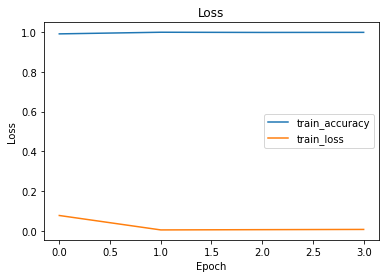

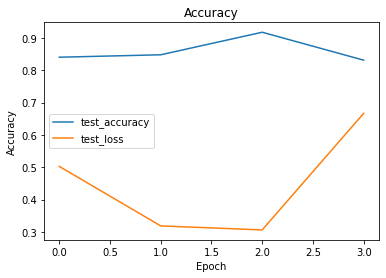

In [22]:
# plot loss
plt.plot(accuracies, label='train_accuracy')
plt.plot(losses, label='train_loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot accuracy
plt.plot(test_accuracies, label='test_accuracy')
plt.plot(test_losses, label='test_loss')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [24]:
cm = confusion_matrix(test_preds_list, test_class)
print(cm)

[[5923  759]
 [1428 4816]]
